<a href="https://colab.research.google.com/github/DiwakarBasnet/paper_implementation/blob/main/ViT_image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle dataset setup

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 244MB/s]


In [3]:
! unzip digit-recognizer.zip
! rm digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Libraries and Parameters

In [4]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [5]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40   # high epoch because we are pre-training not fine-tuning
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS   # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

## Patch Embedding

In [6]:
class PatchEmbedding(nn.Module):
  def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
    super().__init__()
    self.patcher = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        ),
        nn.Flatten(2)
    )

    self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
    self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # -1 to not change that dimension

    x = self.patcher(x).permute(0, 2, 1)
    x = torch.cat([cls_token, x], dim=1)
    x = self.position_embeddings + x
    x = self.dropout(x)
    return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


## Transformer Encoder

In [7]:
class ViT(nn.Module):
  def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
    super().__init__()
    self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

    encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)  # batch_first tells our encoder, in input dimension the first number represents the no. of batches
    self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embed_dim),
        nn.Linear(in_features=embed_dim, out_features=num_classes)
    )

  def forward(self, x):
    x = self.embeddings_block(x)
    x = self.encoder_blocks(x)
    x = self.mlp_head(x[:, 0, :])   # taking only CLS token
    return x


# Checking our work
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Dataset preparation

### Dataset visualization

In [8]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")

In [9]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

### Dataset and Dataloader

In [13]:
class MNISTTrainDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(15),  # for data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx].reshape((28, 28)).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)

    return {"image": image, "label": label, "index": index}


class MNISTValDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([
        # No data augmentation for test data
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx].reshape((28, 28)).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)

    return {"image": image, "label": label, "index": index}


class MNISTSubmitDataset(Dataset):
  def __init__(self, images, indicies):
    self.images = images
    # No labels in submission dataset
    self.indicies = indicies
    self.transform = transforms.Compose([
        # No data augmentation for test data
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx].reshape((28, 28)).astype(np.uint8)
    index = self.indicies[idx]
    image = self.transform(image)

    return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

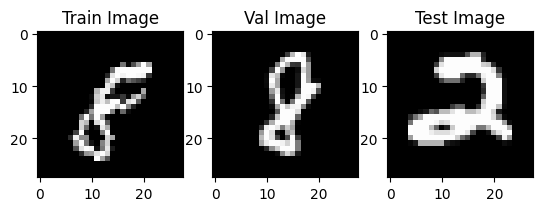

In [14]:
plt.figure()
f, axarr = plt.subplots(1, 3)   # 1-row and 3-col

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

### DataLoader

In [15]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

## Train Loop

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
  model.train()
  train_labels = []
  train_preds = []
  train_running_loss = 0
  for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
    img = img_label["image"].float().to(device)
    label = img_label["label"].type(torch.uint8).to(device)
    y_pred = model(img)
    y_pred_label = torch.argmax(y_pred, dim=1)

    train_labels.extend(label.cpu().detach())   # storing in cpu because gpu will run out of memory
    train_preds.extend(y_pred_label.cpu().detach())

    loss = criterion(y_pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  train_loss = train_running_loss / (idx + 1)

  model.eval()
  val_labels = []
  val_preds = []
  val_running_loss = 0
  with torch.no_grad():   # ensures no learning is happening
    for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
      img = img_label["image"].float().to(device)
      label = img_label["label"].type(torch.uint8).to(device)
      y_pred = model(img)
      y_pred_label = torch.argmax(y_pred, dim=1)

      val_labels.extend(label.cpu().detach())
      val_preds.extend(y_pred_label.cpu().detach())

      loss = criterion(y_pred, label)
      val_running_loss += loss.item()
  val_loss = val_running_loss / (idx + 1)

  print("-"*30)
  print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
  print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
  print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x== y) / len(train_labels):.4f}")
  print(f"Val Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x== y) / len(val_labels):.4f}")
  print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


100%|██████████| 9/9 [00:00<00:00, 11.95it/s]


------------------------------
Train Loss EPOCH 1: 2.2486
Valid Loss EPOCH 1: 2.0561


  2%|▎         | 1/40 [00:22<14:25, 22.19s/it]

Train Accuracy EPOCH 1: 0.1654
Val Accuracy EPOCH 1: 0.2648
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.57it/s]


------------------------------
Train Loss EPOCH 2: 1.9274
Valid Loss EPOCH 2: 1.6954


  5%|▌         | 2/40 [00:43<13:47, 21.77s/it]

Train Accuracy EPOCH 2: 0.3061
Val Accuracy EPOCH 2: 0.4198
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


------------------------------
Train Loss EPOCH 3: 1.6597
Valid Loss EPOCH 3: 1.5144
Train Accuracy EPOCH 3: 0.4315


  8%|▊         | 3/40 [01:05<13:25, 21.77s/it]

Val Accuracy EPOCH 3: 0.5131
------------------------------


100%|██████████| 9/9 [00:02<00:00,  3.34it/s]


------------------------------
Train Loss EPOCH 4: 1.4916
Valid Loss EPOCH 4: 1.3137


 10%|█         | 4/40 [01:29<13:41, 22.82s/it]

Train Accuracy EPOCH 4: 0.5188
Val Accuracy EPOCH 4: 0.6276
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.12it/s]


------------------------------
Train Loss EPOCH 5: 1.3442
Valid Loss EPOCH 5: 1.1795
Train Accuracy EPOCH 5: 0.6036


 12%|█▎        | 5/40 [01:53<13:31, 23.19s/it]

Val Accuracy EPOCH 5: 0.6969
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.15it/s]


------------------------------
Train Loss EPOCH 6: 1.2018
Valid Loss EPOCH 6: 1.1002


 15%|█▌        | 6/40 [02:14<12:46, 22.54s/it]

Train Accuracy EPOCH 6: 0.6751
Val Accuracy EPOCH 6: 0.7052
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


------------------------------
Train Loss EPOCH 7: 1.0957
Valid Loss EPOCH 7: 0.9615


 18%|█▊        | 7/40 [02:36<12:13, 22.22s/it]

Train Accuracy EPOCH 7: 0.7103
Val Accuracy EPOCH 7: 0.7710
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


------------------------------
Train Loss EPOCH 8: 1.0054
Valid Loss EPOCH 8: 0.8882
Train Accuracy EPOCH 8: 0.7360


 20%|██        | 8/40 [02:57<11:42, 21.96s/it]

Val Accuracy EPOCH 8: 0.7876
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


------------------------------
Train Loss EPOCH 9: 0.9279
Valid Loss EPOCH 9: 0.8206


 22%|██▎       | 9/40 [03:19<11:16, 21.82s/it]

Train Accuracy EPOCH 9: 0.7596
Val Accuracy EPOCH 9: 0.8019
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.29it/s]


------------------------------
Train Loss EPOCH 10: 0.8767
Valid Loss EPOCH 10: 0.7648


 25%|██▌       | 10/40 [03:40<10:47, 21.58s/it]

Train Accuracy EPOCH 10: 0.7731
Val Accuracy EPOCH 10: 0.8136
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


------------------------------
Train Loss EPOCH 11: 0.8284
Valid Loss EPOCH 11: 0.7378
Train Accuracy EPOCH 11: 0.7832


 28%|██▊       | 11/40 [04:01<10:23, 21.49s/it]

Val Accuracy EPOCH 11: 0.8176
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 12: 0.7798
Valid Loss EPOCH 12: 0.6913


 30%|███       | 12/40 [04:23<10:00, 21.44s/it]

Train Accuracy EPOCH 12: 0.7954
Val Accuracy EPOCH 12: 0.8317
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


------------------------------
Train Loss EPOCH 13: 0.7366
Valid Loss EPOCH 13: 0.6458


 32%|███▎      | 13/40 [04:44<09:39, 21.48s/it]

Train Accuracy EPOCH 13: 0.8076
Val Accuracy EPOCH 13: 0.8443
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.95it/s]


------------------------------
Train Loss EPOCH 14: 0.6972
Valid Loss EPOCH 14: 0.6239
Train Accuracy EPOCH 14: 0.8187


 35%|███▌      | 14/40 [05:06<09:17, 21.45s/it]

Val Accuracy EPOCH 14: 0.8462
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.99it/s]


------------------------------
Train Loss EPOCH 15: 0.6609
Valid Loss EPOCH 15: 0.5592


 38%|███▊      | 15/40 [05:27<08:56, 21.47s/it]

Train Accuracy EPOCH 15: 0.8308
Val Accuracy EPOCH 15: 0.8695
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.22it/s]


------------------------------
Train Loss EPOCH 16: 0.6240
Valid Loss EPOCH 16: 0.5278
Train Accuracy EPOCH 16: 0.8412


 40%|████      | 16/40 [05:49<08:36, 21.50s/it]

Val Accuracy EPOCH 16: 0.8790
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


------------------------------
Train Loss EPOCH 17: 0.5858
Valid Loss EPOCH 17: 0.5074


 42%|████▎     | 17/40 [06:10<08:15, 21.55s/it]

Train Accuracy EPOCH 17: 0.8508
Val Accuracy EPOCH 17: 0.8845
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


------------------------------
Train Loss EPOCH 18: 0.5621
Valid Loss EPOCH 18: 0.4999
Train Accuracy EPOCH 18: 0.8577


 45%|████▌     | 18/40 [06:32<07:52, 21.47s/it]

Val Accuracy EPOCH 18: 0.8767
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.86it/s]


------------------------------
Train Loss EPOCH 19: 0.5517
Valid Loss EPOCH 19: 0.4770
Train Accuracy EPOCH 19: 0.8569


 48%|████▊     | 19/40 [06:53<07:28, 21.37s/it]

Val Accuracy EPOCH 19: 0.8826
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.31it/s]


------------------------------
Train Loss EPOCH 20: 0.5103
Valid Loss EPOCH 20: 0.4590


 50%|█████     | 20/40 [07:14<07:09, 21.47s/it]

Train Accuracy EPOCH 20: 0.8696
Val Accuracy EPOCH 20: 0.8917
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


------------------------------
Train Loss EPOCH 21: 0.4904
Valid Loss EPOCH 21: 0.4053


 52%|█████▎    | 21/40 [07:36<06:49, 21.55s/it]

Train Accuracy EPOCH 21: 0.8720
Val Accuracy EPOCH 21: 0.9005
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


------------------------------
Train Loss EPOCH 22: 0.4683
Valid Loss EPOCH 22: 0.4285
Train Accuracy EPOCH 22: 0.8781


 55%|█████▌    | 22/40 [07:57<06:26, 21.48s/it]

Val Accuracy EPOCH 22: 0.8943
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.09it/s]


------------------------------
Train Loss EPOCH 23: 0.4533
Valid Loss EPOCH 23: 0.3822


 57%|█████▊    | 23/40 [08:19<06:03, 21.40s/it]

Train Accuracy EPOCH 23: 0.8818
Val Accuracy EPOCH 23: 0.9081
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.18it/s]


------------------------------
Train Loss EPOCH 24: 0.4468
Valid Loss EPOCH 24: 0.4054


 60%|██████    | 24/40 [08:40<05:43, 21.46s/it]

Train Accuracy EPOCH 24: 0.8802
Val Accuracy EPOCH 24: 0.8921
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


------------------------------
Train Loss EPOCH 25: 0.4213
Valid Loss EPOCH 25: 0.3365
Train Accuracy EPOCH 25: 0.8883


 62%|██████▎   | 25/40 [09:02<05:24, 21.60s/it]

Val Accuracy EPOCH 25: 0.9217
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


------------------------------
Train Loss EPOCH 26: 0.4063
Valid Loss EPOCH 26: 0.3248


 65%|██████▌   | 26/40 [09:24<05:01, 21.54s/it]

Train Accuracy EPOCH 26: 0.8915
Val Accuracy EPOCH 26: 0.9188
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.11it/s]


------------------------------
Train Loss EPOCH 27: 0.3988
Valid Loss EPOCH 27: 0.3762


 68%|██████▊   | 27/40 [09:45<04:39, 21.52s/it]

Train Accuracy EPOCH 27: 0.8919
Val Accuracy EPOCH 27: 0.8948
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.20it/s]


------------------------------
Train Loss EPOCH 28: 0.3880
Valid Loss EPOCH 28: 0.3160
Train Accuracy EPOCH 28: 0.8934


 70%|███████   | 28/40 [10:07<04:18, 21.58s/it]

Val Accuracy EPOCH 28: 0.9205
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.55it/s]


------------------------------
Train Loss EPOCH 29: 0.3664
Valid Loss EPOCH 29: 0.3391


 72%|███████▎  | 29/40 [10:29<03:58, 21.67s/it]

Train Accuracy EPOCH 29: 0.9004
Val Accuracy EPOCH 29: 0.9105
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


------------------------------
Train Loss EPOCH 30: 0.3558
Valid Loss EPOCH 30: 0.3084
Train Accuracy EPOCH 30: 0.9035


 75%|███████▌  | 30/40 [10:50<03:34, 21.47s/it]

Val Accuracy EPOCH 30: 0.9171
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.77it/s]


------------------------------
Train Loss EPOCH 31: 0.3491
Valid Loss EPOCH 31: 0.2741
Train Accuracy EPOCH 31: 0.9035


 78%|███████▊  | 31/40 [11:11<03:13, 21.54s/it]

Val Accuracy EPOCH 31: 0.9307
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.24it/s]


------------------------------
Train Loss EPOCH 32: 0.3406
Valid Loss EPOCH 32: 0.2950


 80%|████████  | 32/40 [11:33<02:52, 21.54s/it]

Train Accuracy EPOCH 32: 0.9059
Val Accuracy EPOCH 32: 0.9229
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.32it/s]


------------------------------
Train Loss EPOCH 33: 0.3346
Valid Loss EPOCH 33: 0.2816
Train Accuracy EPOCH 33: 0.9076


 82%|████████▎ | 33/40 [11:54<02:30, 21.53s/it]

Val Accuracy EPOCH 33: 0.9274
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.56it/s]


------------------------------
Train Loss EPOCH 34: 0.3200
Valid Loss EPOCH 34: 0.2680


 85%|████████▌ | 34/40 [12:16<02:08, 21.39s/it]

Train Accuracy EPOCH 34: 0.9106
Val Accuracy EPOCH 34: 0.9248
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


------------------------------
Train Loss EPOCH 35: 0.3114
Valid Loss EPOCH 35: 0.2616


 88%|████████▊ | 35/40 [12:37<01:47, 21.42s/it]

Train Accuracy EPOCH 35: 0.9114
Val Accuracy EPOCH 35: 0.9333
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.84it/s]


------------------------------
Train Loss EPOCH 36: 0.3063
Valid Loss EPOCH 36: 0.3001


 90%|█████████ | 36/40 [12:59<01:26, 21.67s/it]

Train Accuracy EPOCH 36: 0.9140
Val Accuracy EPOCH 36: 0.9233
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


------------------------------
Train Loss EPOCH 37: 0.2897
Valid Loss EPOCH 37: 0.2302
Train Accuracy EPOCH 37: 0.9191


 92%|█████████▎| 37/40 [13:21<01:04, 21.65s/it]

Val Accuracy EPOCH 37: 0.9364
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 38: 0.2909
Valid Loss EPOCH 38: 0.2405


 95%|█████████▌| 38/40 [13:42<00:43, 21.53s/it]

Train Accuracy EPOCH 38: 0.9183
Val Accuracy EPOCH 38: 0.9333
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.98it/s]


------------------------------
Train Loss EPOCH 39: 0.2831
Valid Loss EPOCH 39: 0.2335
Train Accuracy EPOCH 39: 0.9190


 98%|█████████▊| 39/40 [14:04<00:21, 21.57s/it]

Val Accuracy EPOCH 39: 0.9379
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.30it/s]


------------------------------
Train Loss EPOCH 40: 0.2774
Valid Loss EPOCH 40: 0.2294


100%|██████████| 40/40 [14:26<00:00, 21.65s/it]

Train Accuracy EPOCH 40: 0.9211
Val Accuracy EPOCH 40: 0.9379
------------------------------
Training Time: 866.11s


In [19]:
torch.cuda.empty_cache()

In [22]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
  for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
    img = sample["image"].to(device)
    ids.extend([int(i)+1 for i in sample["index"]])

    outputs = model(img)

    imgs.extend(img.detach().cpu())
    labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00,  9.34it/s]


<Figure size 640x480 with 0 Axes>

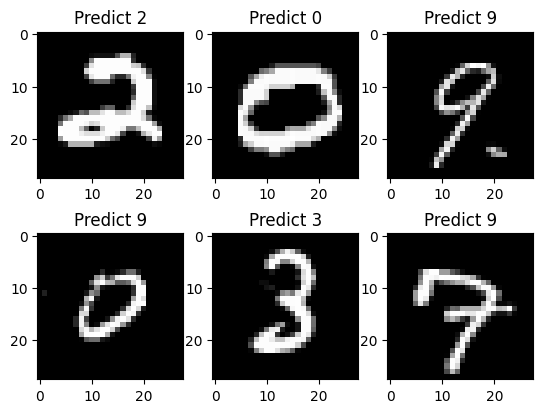

In [25]:
plt.figure()
d, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
  for j in range(3):
    axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
    axarr[i][j].set_title(f"Predict {labels[counter]}")
    counter += 1

plt.show()